In [206]:
import os

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from keras import Sequential, Input
from keras.src.layers import SimpleRNN, Dense, Dropout
from keras.src.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [193]:
# debug
_ = os.system('hostname')
_ = os.system('whoami')
_ = os.system('pwd')

absolute-unit
jrosendahl
/home/jrosendahl/sync/models


In [194]:
data_dir = '/home/jrosendahl/datasets/cadets/sequences'

sequences_raw = []
labels_raw = []

limit = 2000
count = 0

for file_name in os.listdir(data_dir):
    count += 1
    if count > limit:
        break
    with open(os.path.join(data_dir, file_name), 'r') as file:
        sequence = pd.read_csv(file, header=None).iloc[:, 0].tolist()
        sequences_raw.append(sequence)
        labels_raw.append(file_name.split('_')[0])

print(f'loaded {len(sequences_raw)} sequences')

loaded 2000 sequences


In [195]:
# convert labels
# convert to numpy array
labels_np = np.array(labels_raw)

no_classes = len(np.unique(labels_np))
print(f'no_classes: {no_classes}')

# encode labels to integers
labels = np.array([np.unique(labels_np).tolist().index(label) for label in labels_np])

# print first 10 labels
print(f'first 10 labels: {labels[:10]}')
# print first 10 labels reconverted
print(f'first 10 labels reconverted: {[np.unique(labels_np)[label] for label in labels[:10]]}')

# one hot encode labels
labels = np.eye(no_classes)[labels]

# print labels shape
print(f'labels shape: {labels.shape}')


no_classes: 48
first 10 labels: [ 4 37 41  9  4  5  4 14  4 37]
first 10 labels reconverted: ['bash', 'sleep', 'sysctl', 'dd', 'bash', 'cat', 'bash', 'imapd', 'bash', 'sleep']
labels shape: (2000, 48)


In [196]:
# convert sequences into numpy array of shape (no_sequences, max_sequence_length, no_features). one_hot encode features (types)
types = [ 'NONE', 'ACCEPT', 'ADD_OBJECT_ATTRIBUTE', 'BIND', 'CHANGE_PRINCIPAL', 'CLOSE', 'CONNECT', 'CREATE_OBJECT', 'EXECUTE', 'EXIT', 'FCNTL', 'FLOWS_TO', 'FORK',  'LINK', 'LOGIN', 'LSEEK', 'MMAP', 'MODIFY_FILE_ATTRIBUTES', 'MODIFY_PROCESS', 'MPROTECT', 'OPEN', 'OTHER', 'READ', 'RECVFROM', 'RECVMSG', 'RENAME', 'SENDMSG',  'SENDTO', 'SIGNAL', 'TRUNCATE', 'UNLINK', 'WRITE' ]

max_sequence_length = max([len(sequence) for sequence in sequences_raw])

sequences = np.zeros((len(sequences_raw), max_sequence_length, len(types)))

for i, sequence in enumerate(sequences_raw):
    for j, entry in enumerate(sequence):
        sequences[i, j, types.index(entry)] = 1
        
print(f'sequences shape: {sequences.shape}')

sequences shape: (2000, 4106, 32)


In [197]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# print sizes, dimensions
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

print(f'training data shape: {X_train.shape}')
print(f'model input shape: {X_train.shape[1:]}')

X_train: (1280, 4106, 32)
y_train: (1280, 48)
X_val: (320, 4106, 32)
y_val: (320, 48)
X_test: (400, 4106, 32)
y_test: (400, 48)
training data shape: (1280, 4106, 32)
model input shape: (4106, 32)


In [208]:
model = Sequential(layers=[
    Input(shape=X_test.shape[1:]),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64, return_sequences=False),
    Dense(no_classes, activation='softmax'),
])

# early stop callback, validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_112 (SimpleRNN)      │ (None, 4106, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4106, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_113 (SimpleRNN)      │ (None, 4106, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4106, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_114 (SimpleRNN)      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 48)             │         3,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,840 (100.94 KB)

 Trainable params: 25,840 (100.94 KB)

 Non-trainable params: 0 (0.00 B)

In [209]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 798ms/step - accuracy: 0.1576 - loss: 3.5185 - val_accuracy: 0.3625 - val_loss: 2.5142
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 767ms/step - accuracy: 0.4022 - loss: 2.3382 - val_accuracy: 0.3500 - val_loss: 2.3842
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 772ms/step - accuracy: 0.3866 - loss: 2.2927 - val_accuracy: 0.3625 - val_loss: 2.3653
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 772ms/step - accuracy: 0.3978 - loss: 2.1907 - val_accuracy: 0.3625 - val_loss: 2.3583
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 772ms/step - accuracy: 0.4136 - loss: 2.1647 - val_accuracy: 0.3625 - val_loss: 2.3564
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 773ms/step - accuracy: 0.4169 - loss: 2.1112 - val_accuracy: 0.3625 - val_loss: 2.3455
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - accuracy: 0.4016 - loss: 2.1616 - val_accuracy: 0.3625 - val_loss: 2.3524
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - accuracy: 0.4291 - loss: 2.1273 - val_accu

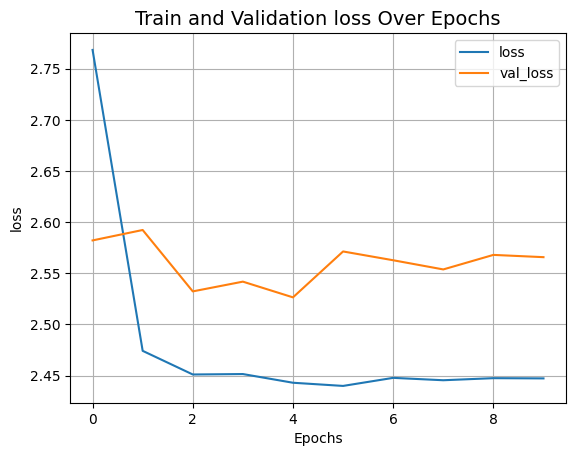

KeyError: 'categorical_crossentropy'

In [201]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_crossentropy")


In [202]:
# predict on test data and evaluate
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(np.array(y_test), axis=1)

print(classification_report(y_test, y_pred))


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.35      1.00      0.52       142
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        23
          15       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         5
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00        18
          20       0.00      0.00      0.00        10
          22       0.00      0.00      0.00         5
          24       0.00      0.00      0.00        12
          25       0.00      0.00      0

/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap